In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

2025-03-27 15:39:42.646804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743057582.753171    4375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743057582.789037    4375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743057583.022347    4375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743057583.022424    4375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743057583.022427    4375 computation_placer.cc:177] computation placer alr

In [22]:
import pickle
import os

# pickle_2 : x, y
# pickle_3 : x, y + 각도

pickle_dir = '/home/shin/deeplearning-repo-1/faa_model/pickle_3/'

dataset = []
labels = []
for file in os.listdir(pickle_dir):
    if file.endswith('.pkl'):
        with open(os.path.join(pickle_dir, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)
            print(file, len(data))

프론트 런지.pkl 6538
스탠딩 니업.pkl 9334
가만히.pkl 5588
스쿼트.pkl 9831
숄더프레스.pkl 3140


In [23]:
X = np.array(dataset)
y = np.array(to_categorical(labels))

X.shape, y.shape

((34431, 20, 32), (34431, 5))

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [25]:
early_stopping = EarlyStopping(
    monitor='loss',      # validation loss를 모니터링
    patience=5,         # 10 epoch 동안 개선 없으면 멈춤
    restore_best_weights=True # 가장 좋은 가중치 복원
)

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(y.shape[1], activation='softmax'))

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(128, return_sequences=True)(inputs)
dropout1 = Dropout(0.3)(x)
attention = Attention()([dropout1, dropout1])
x = LSTM(64)(attention)
dropout2 = Dropout(0.3)(x)
x = Dense(64, activation="relu")(dropout2)
x = Dense(32, activation="relu")(x)
outputs = Dense(y.shape[1], activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=100, callbacks=[early_stopping], validation_data=(X_val, y_val))

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7068 - loss: 0.7630 - val_accuracy: 0.8818 - val_loss: 0.3468
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8848 - loss: 0.3099 - val_accuracy: 0.9275 - val_loss: 0.2030
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9249 - loss: 0.2090 - val_accuracy: 0.9310 - val_loss: 0.1731
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9309 - loss: 0.1873 - val_accuracy: 0.9505 - val_loss: 0.1281
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9392 - loss: 0.1579 - val_accuracy: 0.9219 - val_loss: 0.2254
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9381 - loss: 0.1676 - val_accuracy: 0.9662 - val_loss: 0.0974
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9482 - loss: 0.1445 - val_accuracy: 0.9672 - val_loss: 0.0874
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9588 - loss: 0.1143 - val_accuracy: 0.

In [27]:
model.save('exercise_classifier_angle.h5')

<Figure size 1000x800 with 0 Axes>

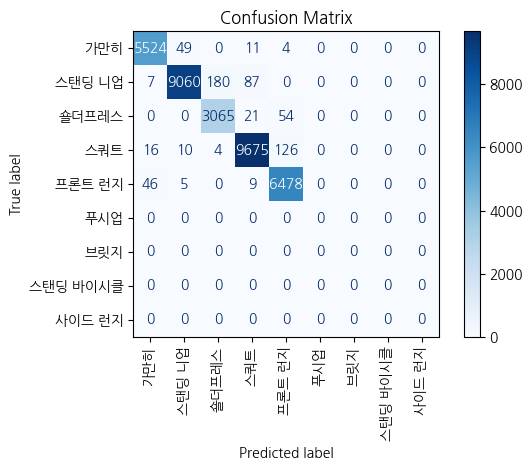

In [29]:
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tensorflow.keras.models import load_model

dataset = []
labels = []

pkl_path = "/home/shin/deeplearning-repo-1/faa_model/pickle_3/"
model_path = "exercise_classifier_angle.h5"
label_names = ["가만히", "스탠딩 니업", "숄더프레스", "스쿼트", "프론트 런지", "푸시업", "브릿지", "스탠딩 바이시클", "사이드 런지"]

# 데이터 로드
for file in os.listdir(pkl_path):
    if file.endswith('.pkl'):   
        with open(os.path.join(pickle_dir, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)

X = np.array(dataset) 
y_true = np.array(labels)

model = load_model(model_path)
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
